In [22]:
from Node import DS
from Tools import Func
from Tools import Config
import pandas as pd
import numpy as np
import os
import time
import operator
import sys
import re

# ==========================UpdateSk==========================
def UpdateSk(element,Sk_head,Sk):
    e_max=Config.e_max
    col,row=Func.position(element)
        # col / row index of element 
    #print("{} send to Sk[{}][{}]".format(element,row,col))
    # ==========================update sketch==========================
    Sk_head[row].count+=element.count
    Sk_head[row].distinct.add(element.ID)
    Sk[row][col]+=1
    Update_local_max(Sk_head[row],Sk[row],element,col)
    Update_emax(Sk_head,Sk,row)

# ==========================update local max==========================       
def Update_local_max(head_item,element_list,element,column):
    # local max need only 1 row
    #print("In Update_local_max:")
    width,depth=Config.width,Config.depth
    if head_item.maxID=='':
        head_item.maxID=element.ID
        head_item.keep=1
    elif head_item.maxID==element.ID:
        head_item.keep+=1
    else:
        local_max_col,local_max_row=Func.position(DS.Tail(head_item.maxID,0))
            # element_list[local_max_col]: lhh的估計值
        if local_max_col==column:
            # lhh collision with e
            head_item.keep-=1
            if head_item.keep==0:
                head_item.maxID=element.ID
                head_item.keep=1
        elif element_list[local_max_col]<element_list[column]:
            # not collision
            head_item.maxID=element.ID
            head_item.keep=1 
          
        '''
        local_max_col,local_max_row=Func.position(DS.Tail(head_item.maxID,0))
            # element_list[local_max_col]: lhh的估計值
        if local_max_col==column:
            # lhh collision with e
            head_item.keep-=1
            if head_item.keep<0:
                head_item.maxID=element.ID
                head_item.keep=1
        elif element_list[local_max_col]<element_list[column]:
            # not collision
            head_item.maxID=element.ID
            head_item.keep=1
            
        local_max_col,local_max_row=Func.position(DS.Tail(head_item.maxID,0))
            # element_list[local_max_col]: lhh的估計值            
        if element_list[local_max_col]<element_list[column]:
            head_item.maxID=element.ID            
        '''
        


# ==========================update e_max==========================
def Update_emax(head,sketch,sk_row):
    local_max_col,local_max_row=Func.position(DS.Tail(head[sk_row].maxID,0))
    if sketch[local_max_row][local_max_col]>Config.e_max.count:
        Config.e_max.ID=head[sk_row].maxID
        Config.e_max.count=sketch[local_max_row][local_max_col]

# ========================== BringBack=========================
def BringBack(e_min,head,sketch):
    # bring e_max back to Top
    # e_min=e_max, e_max=Null, delete e_max.count in Sketch, send e_min into Sketch
    temp=DS.Tail(e_min.ID,e_min.count)
    e_min.ID=Config.e_max.ID
    e_min.count=Config.e_max.count
    c,r=Func.position(Config.e_max)
    head[r].bringback+=1
    DeleteSk(e_max,head,sketch)
    UpdateSk(temp,head,sketch)

# ==========================DeleteSk=========================
def DeleteSk(element,head,sketch):
    # e_max in sketch: sketch[r][c]=0, total count-=sketch[row][col]
    #width,depth=get_width_depth()
    col,row=Func.position(element)
    head[row].count-=element.count
        # total_count-=element.count
    sketch[row][col]=0
    head[row].maxID=''
    element.ID=""
    element.count=0

    
# ==========================main=========================    
dataset='caida'
datapath=r"..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(datapath)))

w=256
d=128
size=1024
Config.Set_default(w,d,size)
    # set width, depth, size of Sk, random seed of hash
    # Config.width, Config.depth
e_max=Config.e_max
    # initialize e_max
    
Sk_head=[DS.Head(0) for j in range(Config.depth)]
Sketch=np.zeros((Config.depth,Config.width),dtype='int32')
Top=[]

#item_count=100
#income=0
start=time.time()
for datafile in filelist[:1]:
    src_data=os.path.join(datapath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while True:
            e=str(file.read(13))
            if len(e)<13:
                print('EOF')
                break
            else:
                # item_count-=1
                #income+=1
                #print("read {}-th element:{}".format(income,e))
                item=DS.Tail(e,1)
                index=Func.find(item,Top)
                if index<0:
                    if len(Top)<Config.size:
                        Top.append(item)
                        # 此處的count必等於1，不用sorting
                        index=len(Top)-1
                    else:
                        UpdateSk(item,Sk_head,Sketch)
                else:
                    Top[index].count+=1
                    if index==0 or Top[index].count< Top[index-1].count:
                        pass
                    else:
                        Top.sort(key=operator.attrgetter('count'),reverse=True)                
            if Config.e_max.count>Top[-1].count:
                BringBack(Top[-1],Sk_head,Sketch)
                Top.sort(key=operator.attrgetter('count'),reverse=True)
                #print('Top after BringBack: \n\t{}'.format(Top)) 

end=time.time()
print("Top-{},Sketch:{}*{}".format(Config.size,Config.depth,Config.width))
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Total memory {} bytes=".format(sys.getsizeof(Top)+Sketch.nbytes+sys.getsizeof(Sk_head[0])*Config.depth),end='')
print("Top:{} bytes, Sketch:{} bytes, Sketch_head:{} bytes.".format(sys.getsizeof(Top),Sketch.nbytes,sys.getsizeof(Sk_head[0])*Config.depth))

#====================Top to csv=============================
my_csv_file=Func.Top_to_csv(Top,dataset)
    # return "My_OO_kosarak_Top_512_128_256.csv"

#====================result compare=============================
# precision
gr_dir=r"..\dataset\caida"
gr_file_name='caida_0_ground_truth.csv'
gr_path=os.path.join(gr_dir,gr_file_name)
    # gr_path="..\dataset\kosarak\kosarak_ground_truth.csv"
my_result_path=os.path.join(r'..\result',my_csv_file)
    # my_result_path="..\result\My_OO_kosarak_Top_512_128_256.csv"
true_positive_set,precision=Func.Get_precision(gr_path,my_result_path)

# ====================ARE/AAE for top and all====================



'''
startx=time.time()
top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,my_result_path,Top,Sk_head,Sketch,2)
endx=time.time()
print("Query2:")
print("Find:{}, TP:{}, FP:{}".format(len(true_positive_set),tp,fp))
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.6f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.6f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))


startx=time.time()
top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,my_result_path,Top,Sk_head,Sketch,1)
endx=time.time()

print("Query1:")
print("Find:{}, TP:{}, FP:{}".format(len(true_positive_set),tp,fp))
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.6f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.6f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

startx=time.time()
top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,my_result_path,Top,Sk_head,Sketch,3)
endx=time.time()
print("Query3:")
print("Find:{}, TP:{}, FP:{}".format(len(true_positive_set),tp,fp))
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.6f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.6f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

startx=time.time()
top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,my_result_path,Top,Sk_head,Sketch,4)
endx=time.time()
print("Query4:")
print("Find:{}, TP:{}, FP:{}".format(len(true_positive_set),tp,fp))
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.6f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.6f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

'''

# ====================Cover result into a dataframe====================
result_para=(startx,endx,true_positive_set,precision,top_are,top_aae,all_are,all_aae,tp,fp)
df=Func.To_df(Top,Sketch,Sk_head,*result_para)
df

EOF
Top-1024,Sketch:128*256
Execution time: 366.108 seconds.
Total memory 147264 bytes=Top:9024 bytes, Sketch:131072 bytes, Sketch_head:7168 bytes.
My_OO_caida_Top_1024_128_256.csv
Precision:   0.8906


,Top-k,Sketch,Total memory,Exe_time,Find,Precision,ARE-Top,AAE-Top,ARE-all,AAE-all
0,1024,128*256,147264 bytes =Top:9024+ Sketch:131072+ Sk_head...,6.82,"Find:912, TP:206, FP:50",0.8906,0.06073,104.834951,0.568613,10.164818


In [25]:
print([i.keep for i in Sk_head])
Top[-1]

[7, 1, 8, 8, 3, 39, 9, 4, 11, 11, 61, 47, 12, 6, 1, 67, 19, 2, 2, 36, 4, 64, 3, 10, 4, 6, 2, 1, 10, 26, 22, 1, 3, 11, 2, 18, 38, 10, 41, 88, 2, 76, 11, 13, 11, 7, 2, 12, 37, 44, 3, 1, 52, 2, 2, 4, 74, 23, 44, 2, 6, 9, 1, 5, 4, 52, 21, 30, 10, 22, 5, 35, 5, 31, 16, 27, 7, 8, 2, 4, 25, 4, 27, 5, 1, 7, 1, 5, 2, 3, 7, 4, 63, 14, 38, 19, 8, 5, 4, 124, 32, 11, 80, 5, 9, 3, 6, 13, 13, 3, 30, 1, 7, 18, 29, 38, 55, 1, 82, 5, 4, 1, 28, 44, 7, 5, 40, 23]


[ID: b'#\xf0\xc2\xd9\x01\xbbc\x13\xe7t\x10$\x06', count: 258]

In [63]:
sum_0=sum(i for i in Sketch[0])
print("total count in Sketch[0]:{}, in Sk_head[0]:{},avg count:{}".format(sum_0,Sk_head[0].count,sum_0//len(Sk_head[0].distinct)))
print("distinct element in Sketch[0]:{}".format(len(Sk_head[0].distinct)))
print(Sketch[0])
row_cardinality=[len(i.distinct) for i in Sk_head]
print(Sk_head[0].maxID,Sk_head[0].keep,Func.Query2(r"b'\x85[z\x1e\x1bbCb\x04C\xe4=\x06'",Top,Sk_head,Sketch,row_cardinality))
c,r=Func.position(DS.Tail(r"b'\x85[z\x1e\x1bbCb\x04C\xe4=\x06'",0))
print(Sketch[r][c])
print("ratio:{}".format(Config.width/row_cardinality[0]))

Sketch[0].median()

total count in Sketch[0]:9854, in Sk_head[0]:10590,avg count:6
distinct element in Sketch[0]:1408
[ 16 215  35   7  11  14  48  64   4 167  60  39  82   2  75  42  77   5
   5  13  48  23   2  14  36  53 113   9  29  17  12  19  29 204  15  55
   8  34  22 166  77  10 120  19  25  28  12  15  38  48  38  12  18  44
  68  26   6  30  49 195  17  54  58  71  27  35  37  61  10  12   0   9
  25  19  38  23  39   8   4  60   5  30  43 175  19  32  54   9   3  12
  30  13  31  17  53  10  43  17   1  49   9  33 154  48  24  25  12  23
  47  35  19  38  51  24  59  50  14  14  10  15  25 126  34   3  85 105
  35  20  23  14  42  36  13  41   5 116  11  47  89  15  39  35  21   7
  26  30  14  26   5  71   4   4  10  42  72  70  54 170   6  70  63  68
  62 110  25  30  19  10   2  26  31  44  22  17  26  23  42  36   7  80
   2  22  23  29  54  20  13  21  59   5  50  34  25  45  58  77  72  64
  14  17  89  57  15  10   3  40  14  13  51 157  54  44  32  27  26  37
   9  44   8   3  43  20  

AttributeError: 'numpy.ndarray' object has no attribute 'median'

In [69]:
import numpy as np
np.median(Sketch[0])

29.0

In [53]:
gt_dict=dict(grtruth.values.tolist())
gt_dict[r"b'\x85[z\x1e\x1bbCb\x04C\xe4=\x06'"]

202

In [41]:
gr_dir=r"..\dataset\caida"
gr_file_name='caida_0_ground_truth.csv'
grtruth=pd.read_csv(os.path.join(gr_dir,gr_file_name))

print("Top[{}]:truth:{}, algo result:{}".format(Config.size,grtruth['Count'][:Config.size].sum(),sum([i.count for i in Top])))
print("sum of Sketch:{}".format(Sketch.sum()))
print("sum of Sk_head:{}".format(sum([j.count for j in Sk_head])))

# print("sum of all count of algo:{}".format(sum([i.count for i in Top])+Sketch.sum()))
print("sum of Top + Sk_head: {}".format(sum([i.count for i in Top])+sum([j.count for j in Sk_head])))
print("all arriving element: {}".format(grtruth['Count'].sum()))

Top[1024]:truth:945834, algo result:933951
sum of Sketch:1338427
sum of Sk_head:1538776
sum of Top + Sk_head: 2472727
all arriving element: 2472727


In [ ]:
print([i.count for i in Top])

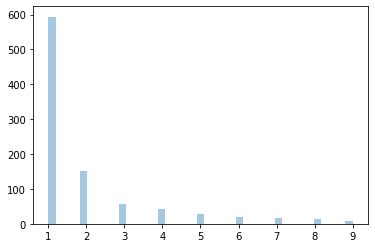

In [10]:
'''
a - distribution parameter.

size - The shape of the returned array.
'''
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

x = random.zipf(a=2, size=1000)
sns.distplot(x[x<10], kde=False)

plt.show()